<a href="https://colab.research.google.com/github/DarthCipher7/DR/blob/main/DR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
### Cell 1: Mount Drive and Unzip Data ###

# Import necessary libraries
import os
import zipfile
from google.colab import drive

# Mount your Google Drive (this will require authentication)
drive.mount('/content/drive')

# Define the path to your zip file
zip_path = '/content/drive/MyDrive/Colab Notebooks/data.zip'

# Define the directory to extract the data to
extract_path = '/content/data'

# Create the extraction directory if it doesn't exist
os.makedirs(extract_path, exist_ok=True)

# Unzip your data
print("Starting to unzip the data...")
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)
print("Data unzipped successfully!")

# You can add this to see the contents of your unzipped folder
print("\nContents of the data folder:")
!ls /content/data

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Starting to unzip the data...
Data unzipped successfully!

Contents of the data folder:
data


In [16]:
### Cell 2: Load Labels and Prepare Data Generators (with Augmentation) ###

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

main_data_dir = '/content/data/data/gaussian_filtered_images/gaussian_filtered_images'

# --- UPGRADE: Create separate generators for training (with augmentation) and validation ---

# This is for the training data - we apply lots of random transformations
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,   # Still split the data
    rotation_range=20,      # Randomly rotate images
    width_shift_range=0.1,  # Randomly shift images horizontally
    height_shift_range=0.1, # Randomly shift images vertically
    shear_range=0.1,        # Apply shear transformations
    zoom_range=0.1,         # Randomly zoom in on images
    horizontal_flip=True,   # Randomly flip images horizontally
    fill_mode='nearest'
)

# This is for the validation data - we ONLY rescale it. No augmentation!
# We need to judge the model on the original, unmodified images.
validation_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

# --- Create the generators using the new datagens ---

train_generator = train_datagen.flow_from_directory(
    directory=main_data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = validation_datagen.flow_from_directory(
    directory=main_data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)


Found 2931 images belonging to 5 classes.
Found 731 images belonging to 5 classes.


In [20]:
### Cell 3: Build the Model for Fine-Tuning ###

from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam # Import the Adam optimizer

# --- Step 1: Reload the best model you just saved ---
# We start from the best model we found in the last run.
# Make sure 'best_retinopathy_model.keras' is in your file directory!
model = tf.keras.models.load_model('best_retinopathy_model.keras')

# --- Step 2: Un-freeze the top layers of the base model ---
# The base model is the first layer of your sequential model
base_model = model.layers[0]

# We let the last 4 layers of VGG16 be trainable
base_model.trainable = True
for layer in base_model.layers[:-4]:
    layer.trainable = False

# --- Step 3: Re-compile the model with a VERY LOW learning rate ---
# This is crucial for fine-tuning. We don't want to destroy the pre-trained weights.
model.compile(
    optimizer=Adam(learning_rate=1e-5), # Use a much smaller learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Print a summary to see the changes in trainable parameters
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │         2,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,562,821 (105.14 MB)

 Trainable params: 19,927,557 (76.02 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [21]:
### Cell 4: Train the Model (with Callbacks and More Epochs) ###

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# --- UPGRADE: Define callbacks ---

# Stop training if the validation loss doesn't improve for 5 consecutive epochs
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    restore_best_weights=True  # Automatically restore the best model weights at the end
)

# Save the best model found during training to a file
model_checkpoint = ModelCheckpoint(
    'best_retinopathy_model.keras', # File name to save the model
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)


# --- Train for more epochs ---
history = model.fit(
    train_generator,
    epochs=30,  # Increase the number of epochs significantly
    validation_data=validation_generator,
    callbacks=[early_stopping, model_checkpoint] # Add the callbacks here
)


Epoch 1/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 518ms/step - accuracy: 0.7122 - loss: 0.8314
Epoch 1: val_loss improved from inf to 0.73614, saving model to best_retinopathy_model.keras
92/92 ━━━━━━━━━━━━━━━━━━━━ 60s 589ms/step - accuracy: 0.7121 - loss: 0.8315 - val_accuracy: 0.7237 - val_loss: 0.7361
Epoch 2/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step - accuracy: 0.7090 - loss: 0.8170
Epoch 2: val_loss improved from 0.73614 to 0.72540, saving model to best_retinopathy_model.keras
92/92 ━━━━━━━━━━━━━━━━━━━━ 74s 544ms/step - accuracy: 0.7091 - loss: 0.8170 - val_accuracy: 0.7346 - val_loss: 0.7254
Epoch 3/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step - accuracy: 0.7121 - loss: 0.8207
Epoch 3: val_loss did not improve from 0.72540
92/92 ━━━━━━━━━━━━━━━━━━━━ 49s 531ms/step - accuracy: 0.7122 - loss: 0.8205 - val_accuracy: 0.7291 - val_loss: 0.7257
Epoch 4/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 504ms/step - accuracy: 0.7289 - loss: 0.7733
Epoch 4: val_loss improved from 0.72540 to 0.70808, saving model 

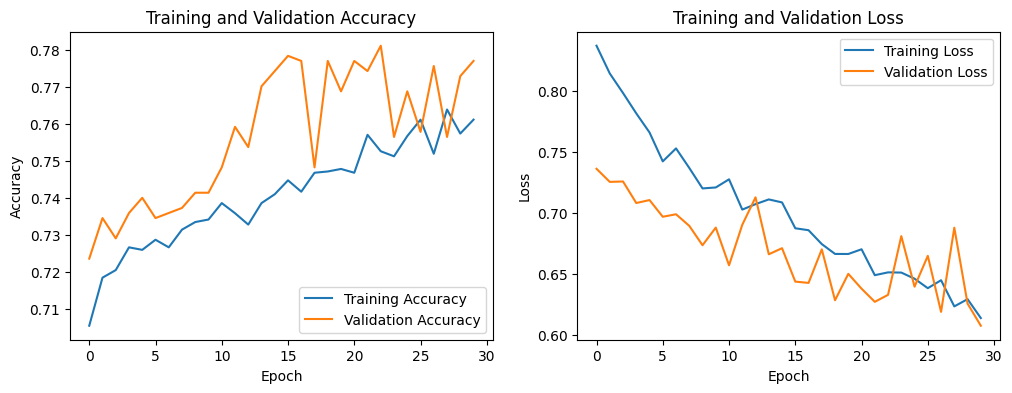

In [22]:
### Cell 5: Evaluate the Model ###

import matplotlib.pyplot as plt

# Plot the training and validation accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plot the training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

In [23]:
# Load your best fine-tuned model
final_model = tf.keras.models.load_model('best_retinopathy_model.keras')

# Evaluate its performance on the validation set
print("Evaluating the final model...")
final_scores = final_model.evaluate(validation_generator)

print(f"\nFinal Validation Loss: {final_scores[0]}")
print(f"Final Validation Accuracy: {final_scores[1]}")


Evaluating the final model...
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 165ms/step - accuracy: 0.8112 - loss: 0.5526

Final Validation Loss: 0.6075456738471985
Final Validation Accuracy: 0.7770177721977234
